Prepare an image file foler and a json file folder , this notebook can use maskrcnn to predict the mask and compute the iou.

# Initial MaskRCNN

In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import math
from skimage.draw import polygon
from skimage.feature import peak_local_max
import torch.nn.functional as F
import json
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content
!git clone https://github.com/Austin-Huang1014/Mask-RCNN-Detectron2.git
sys.path.append('/content/Mask-RCNN-Detectron2')

/content
fatal: destination path 'Mask-RCNN-Detectron2' already exists and is not an empty directory.


In [ ]:
!pip install -U git+https://github.com/facebookresearch/fvcore.git
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import os 
import gdown
import torch
import logging
from zipfile import ZipFile

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
import struct
import math
import time
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

Download datasets

In [5]:
dataset_url = 'https://drive.google.com/u/1/uc?id=1R3XJNp39vBzamU3A48jp9bmJQ_tEMxUz&export=download'
dataset_name = 'datasets'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
    zip1 = ZipFile('/content/datasets' + '.zip')
    zip1.extractall('/content/datasets')
    zip1.close()

print("Finished downloading dataset.")

Finished downloading dataset.


In [6]:
register_coco_instances('val', {}, 
								'/content/datasets/subt_new/test.json', 
							'/content/datasets/subt_new/subt_test')

In [7]:
path = ''
metadata = MetadataCatalog.get("val")
# metadata.thing_classes[2] = 'survivor'
dataset_dicts = DatasetCatalog.get("val")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = os.path.join('/content/output/model.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Download weight

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
models_url = "https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1lgo2nF_fRd9Bb9Zvt0ENTUKlZPIAIAUw&export=download"
models_name = "model.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.")

Downloading...
From: https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1lgo2nF_fRd9Bb9Zvt0ENTUKlZPIAIAUw&export=download
To: /content/output/model.pth
351MB [00:07, 44.7MB/s]


Finished downloading models.


Initial predictor

In [10]:
predictor = DefaultPredictor(cfg)

Main function

In [116]:
class MaskRCNN_IOU(object):
  def __init__(self, predictor, data_path, Metadata): # need predictor , data path that contain image and json file folders and information of classes
    self.classes = Metadata.thing_classes[1:] # predictor class
    # self.classes[1] = 'survivor'
    self.img_size = None
    self.path = data_path
    self.predictor = predictor
    self.image_list = []
    self.mask_list = []
    self.classes_list = []
    self.AP = np.zeros((len(self.classes)))
    self.figure = [None,None]
    self.data_load()
  
  def mask2mask(self,mask): # convert detectron type mask to polygon type mask
    canvas  =  np.zeros((self.img_size[0], self.img_size[1], 3), dtype = "uint8")
    for i in range(self.img_size[0]):
      for j in range(self.img_size[1]):
        if mask[i,j] == True:
            canvas[i,j] = 255

    gray = cv2.cvtColor(canvas,cv2.COLOR_BGR2GRAY)  
    ret, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    tt = np.array(contours)[0]
    polygon = np.reshape(tt,(tt.shape[0],2))
    return polygon
  
  def perception(self,data): # make prediction , return detectron type mask and class
    Mask = []
    outputs = self.predictor(data)
    v = Visualizer(data[:, :, ::-1],
					    metadata=metadata,
					    scale=0.8, 
				    #	 instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
		    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    clss = outputs["instances"].pred_classes.cpu().numpy()
    Img = v.get_image()[:, :, ::-1]
    self.figure[0] = Img[:,:,[2,1,0]]
    gg = outputs["instances"].pred_masks.cpu().numpy()
    num = gg.shape[0]
    for i in range(num):
      m = self.mask2mask(gg[i])
      Mask.append(m)
    return Mask, clss

  def json2polygon(self,path): # read json file and get polygon type mask and class
    Classes = 0
    with open(path,"r") as f:
      data = json.load(f)
      polygon = np.array(data['shapes'][0]['points'],dtype=np.int32)
      label = data['shapes'][0]['label']

      # modify to ypur own classes
      index = self.classes.index(label)
      Classes = index

    return polygon, Classes


  def data_load(self): # load image and json file and create the data list
    directory = [self.path + '/image',self.path + '/json']
    path_ = [os.listdir(directory[0]), os.listdir(directory[1])] 
    path_[0].sort()
    path_[1].sort()
    check = []
    Check = []
    for filename in path_[0]:
      check.append(filename.split('.')[0])
      img = cv2.imread(directory[0] + "/" + filename)
      self.image_list.append(img)
    self.img_size  = [img.shape[0],img.shape[1]]
    
    for filename in path_[1]:
      Check.append(filename.split('.')[0])
      mask, cls = self.json2polygon(directory[1] + "/" + filename)
      self.AP[cls] += 1
      self.mask_list.append(mask)
      self.classes_list.append(cls)
    
    diff = list(set(check).symmetric_difference(set(Check)))
    if len(diff) == 0:
      print('Image path :',directory[0])
      print('Label file path : ',directory[1])
      print('Load ',len(self.image_list),' data')
      print('Image size :',self.img_size[0],'x',self.img_size[1])
      print('Class List : ',self.classes)
      for j in range(len(self.classes)):
        print(self.classes[j],' : ',int(self.AP[j]),' images')
    else:
      print('Find some file loss , please check the filename : ',diff)
    

  def draw_polygon(self,polygon__): # draw mask with the polygon type mask
    canvas  =  np.zeros((self.img_size[0], self.img_size[1], 3), dtype = "uint8")
    points  =  polygon__.reshape((-1, 1, 2))
    cv2.fillPoly(canvas,[points],(255,255,255))
    self.figure[1] = canvas

  def polygon_IOU(self,polygon_1, polygon_2): # compute iou
    """
    count iou of two polygon
    :param polygon_1: [[row1, col1], [row2, col2], ...]
    :param polygon_2: same as above
    :return:
    """
    rr1, cc1 = polygon(polygon_2[:, 0], polygon_2[:, 1])
    rr2, cc2 = polygon(polygon_1[:, 0], polygon_1[:, 1])

    try:
        r_max = max(rr1.max(), rr2.max()) + 1
        c_max = max(cc1.max(), cc2.max()) + 1
    except:
        return 0

    canvas = np.zeros((r_max, c_max))
    canvas[rr1, cc1] += 1
    canvas[rr2, cc2] += 1
    union = np.sum(canvas > 0)
    if union == 0:
        return 0
    intersection = np.sum(canvas == 2)

    return intersection / union

  def IOU(self): # main function
    count = np.zeros((len(self.classes)))
    for i in range(len(self.mask_list)):
      print('================================================= Frame : ',i,' =================================================')
      print('Class : ',self.classes[self.classes_list[i]])
      pred, clss = self.perception(self.image_list[i])
      temp = []
      get = 0
      for j in range(len(pred)):
        # confirm if is the correct class
        if (clss[j]-1) == self.classes_list[i]:
          get += 1
          iou = self.polygon_IOU(self.mask_list[i], pred[j])
          temp.append(iou)
      
      self.draw_polygon(self.mask_list[i])
      plt.figure(figsize=(15,15))
      plt.subplot(121)
      plt.title('Prediction Result')
      plt.imshow(self.figure[0])
      plt.subplot(122)
      plt.title('Label')
      plt.imshow(self.figure[1])
      plt.show()
      if get != 0:
        # Find the maximum iou
        index = temp.index(max(temp))
        if temp[index] != 0.0:
          print('IOU : ',temp[index])
          if temp[index] >= 0.5:
            count[self.classes_list[i]] += 1 
        else:
          print('No detect')
      else:
        print('No detect')
  
      print('Detect : ',int(np.sum(count)),' / ',len(self.mask_list),'\n')
    print('\n'+'Detect Result :'+'\n')
    for i in range(len(self.classes)):
      print(self.classes[i],' : ',int(count[i]),' / ',int(self.AP[i]))


Data path

In [75]:
Path = '/content/gdrive/MyDrive/test'

Initial

In [119]:
eval = MaskRCNN_IOU(predictor, Path, metadata)

Image path : /content/gdrive/MyDrive/test/image
Label file path :  /content/gdrive/MyDrive/test/json
Load  10  data
Image size : 480 x 640
Class List :  ['backpack', 'suvivor', 'vent', 'phone']
backpack  :  4  images
suvivor  :  2  images
vent  :  2  images
phone  :  2  images


Result

================================================= Frame :  0  =================================================
Class :  backpack


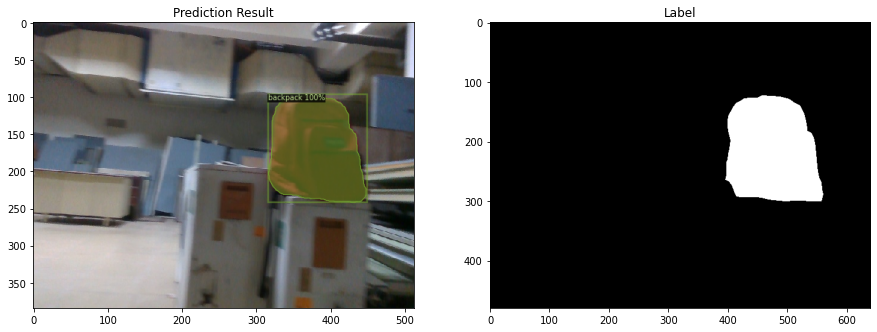

IOU :  0.9635366917230782
Detect :  1  /  10 

================================================= Frame :  1  =================================================
Class :  backpack


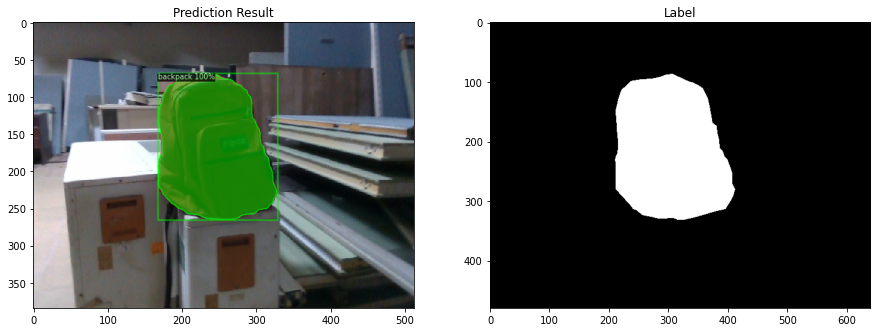

IOU :  0.9727448204864239
Detect :  2  /  10 

================================================= Frame :  2  =================================================
Class :  backpack


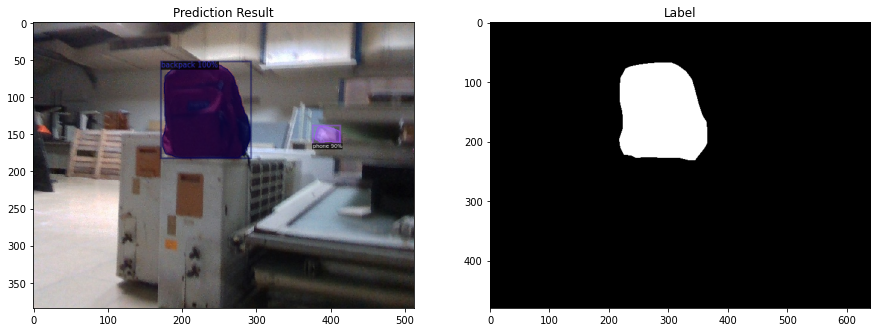

IOU :  0.9688051795173631
Detect :  3  /  10 

================================================= Frame :  3  =================================================
Class :  backpack


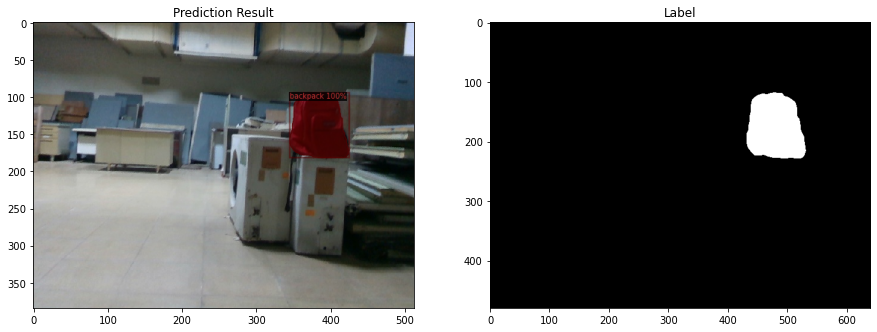

IOU :  0.9620767494356659
Detect :  4  /  10 

================================================= Frame :  4  =================================================
Class :  phone


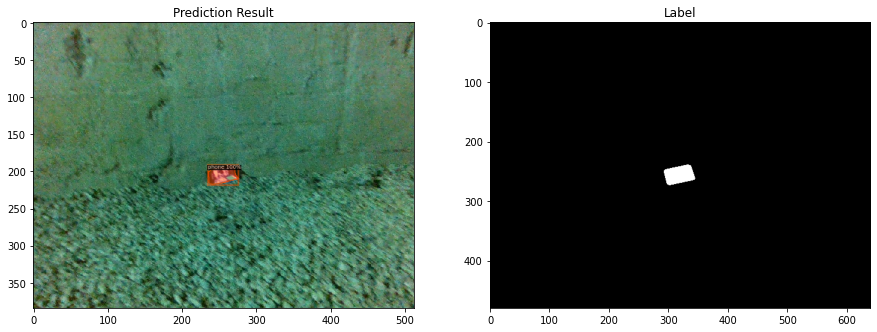

IOU :  0.8878281622911695
Detect :  5  /  10 

================================================= Frame :  5  =================================================
Class :  phone


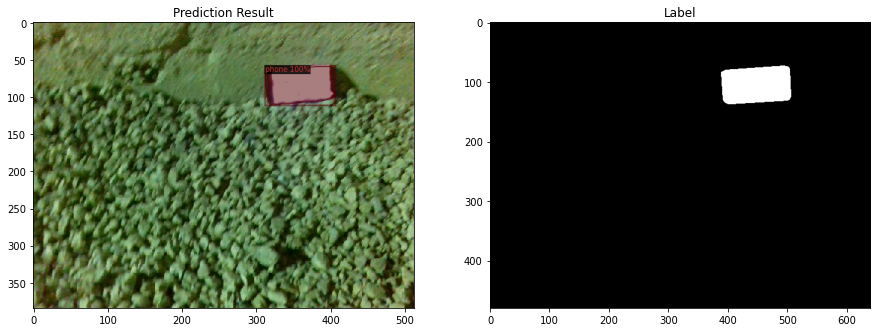

IOU :  0.9556761646313885
Detect :  6  /  10 

================================================= Frame :  6  =================================================
Class :  suvivor


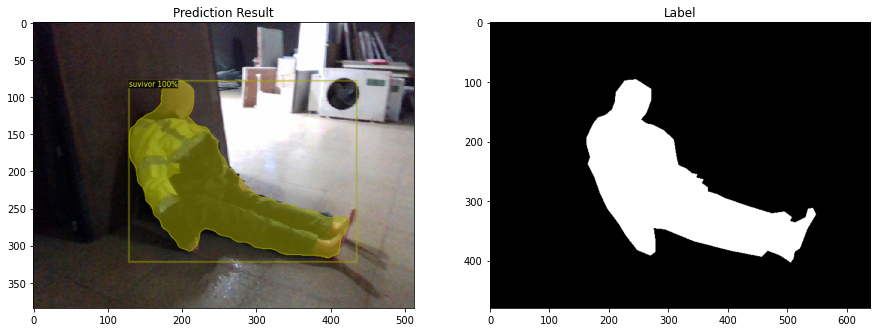

IOU :  0.934008473700527
Detect :  7  /  10 

================================================= Frame :  7  =================================================
Class :  suvivor


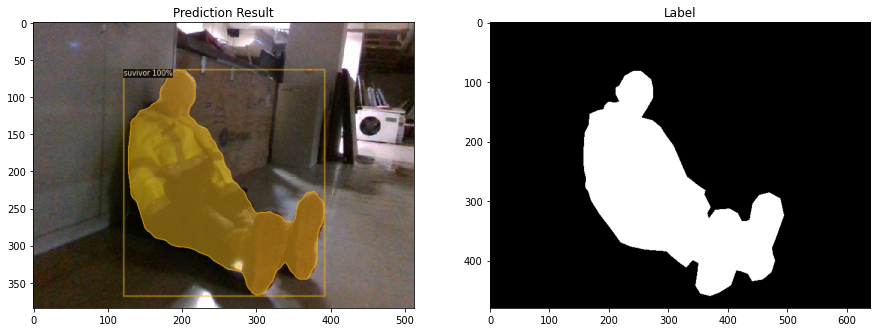

IOU :  0.9309503497696638
Detect :  8  /  10 

================================================= Frame :  8  =================================================
Class :  vent


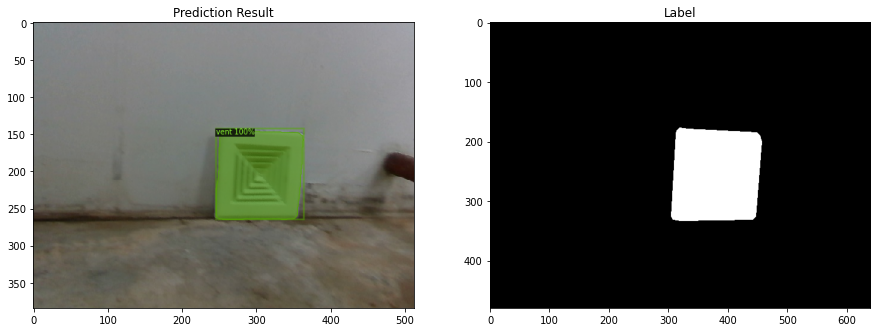

IOU :  0.9530828605970427
Detect :  9  /  10 

================================================= Frame :  9  =================================================
Class :  vent


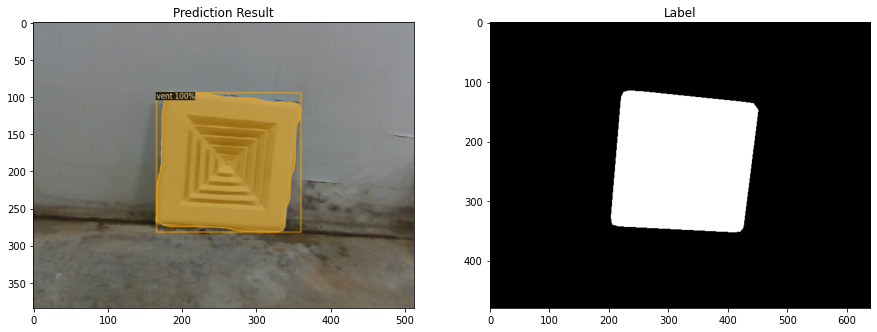

IOU :  0.9699093727170415
Detect :  10  /  10 


Detect Result :

backpack  :  4  /  4
suvivor  :  2  /  2
vent  :  2  /  2
phone  :  2  /  2


In [120]:
eval.IOU()